In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from eli5.sklearn import PermutationImportance

In [2]:
election_data_path = '../../datasets/Clean Datasets/Electoral Data/'
census_data_path = '../../datasets/Clean Datasets/Census Data/'
other_data_path = '../../datasets/Raw Datasets/Other data/'

In [3]:
all_df = pd.read_csv('../../datasets/Clean Datasets/' + 'CED to All Demographics and Results.csv', index_col=0)
all_df_norm = pd.read_csv('../../datasets/Clean Datasets/' + 'CED to All Demographics and Results Norm.csv', index_col=0)
all_df.dropna(inplace=True)
all_df_norm.dropna(inplace=True)

In [4]:
set(all_df_norm['PartyNm'])

{'Australian Labor Party',
 'Australian Labor Party (Northern Territory) Branch',
 'Centre Alliance',
 'Independent',
 "Katter's Australian Party (KAP)",
 'Labor',
 'Liberal',
 'Liberal National Party of Queensland',
 'The Greens (VIC)',
 'The Nationals'}

In [5]:
all_df_norm_major_groups = all_df_norm.copy()
all_df_norm['PartyNm'].replace('Australian Labor Party (Northern Territory) Branch', 'Labor', inplace=True)
all_df_norm['PartyNm'].replace('Australian Labor Party', 'Labor', inplace=True)
#all_df_norm['PartyNm'].replace('Liberal National Party of Queensland', 'Liberal', inplace=True)
#all_df_norm['PartyNm'].replace('Independent', 'Independent/Minor', inplace=True)
#all_df_norm['PartyNm'].replace('Katter\'s Australian Party (KAP)', 'Independent/Minor', inplace=True)
#all_df_norm['PartyNm'].replace('The Greens (VIC)', 'Independent/Minor', inplace=True)
#all_df_norm['PartyNm'].replace('Centre Alliance', 'Independent/Minor', inplace=True)

all_df_norm_major_groups['PartyNm'].replace('Labor', 'ALP', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Australian Labor Party (Northern Territory) Branch', 'ALP', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Australian Labor Party', 'ALP', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Independent', 'Independent/Minor', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Katter\'s Australian Party (KAP)', 'Independent/Minor', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('The Greens (VIC)', 'Independent/Minor', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Centre Alliance', 'Independent/Minor', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Liberal National Party of Queensland', 'Coalition', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('Liberal', 'Coalition', inplace=True)
all_df_norm_major_groups['PartyNm'].replace('The Nationals', 'Coalition', inplace=True)
set(all_df_norm_major_groups['PartyNm'])

{'ALP', 'Coalition', 'Independent/Minor'}

### KNN Analysis

In [6]:
X = all_df_norm_major_groups.drop(columns=['PreferencePercent', 'PartyNm'])
y = all_df_norm_major_groups['PartyNm']
train, test = train_test_split(all_df_norm_major_groups, test_size=0.2, random_state=42)
train_X = train.drop(columns=['PreferencePercent','PartyNm'])
train_y = train['PartyNm']
test_X = test.drop(columns=['PreferencePercent','PartyNm'])
test_y = test['PartyNm']

In [7]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=7)

In [8]:
print(accuracy_score(train_y, knn.predict(train_X)))
print(accuracy_score(test_y, knn.predict(test_X)))

0.8166666666666667
0.6451612903225806


In [9]:
pd.DataFrame(confusion_matrix(test_y, knn.predict(test_X)),
             index=['Coalition', 'Independent/Minor', 'ALP'],
             columns=['Coalition', 'Independent/Minor', 'ALP'])

,Coalition,Independent/Minor,ALP
Coalition,9,4,0
Independent/Minor,4,11,0
ALP,1,2,0


In [10]:
result = pd.DataFrame(test['PartyNm'])
result.columns = ["Actual"]
result.insert(1, "Predicted", knn.predict(test_X))
result.insert(2, "Pref Percent", test['PreferencePercent'].values)
display(result)

,Actual,Predicted,Pref Percent
LGA,,,
Hughes,Coalition,Coalition,59.85
Brand,ALP,Coalition,56.66
Kennedy,Independent/Minor,Coalition,63.33
Jagajaga,ALP,Coalition,56.57
Warringah,Independent/Minor,Coalition,57.24
Cook,Coalition,Coalition,69.02
Hunter,ALP,ALP,52.98
Grayndler,ALP,ALP,66.30
Fowler,ALP,ALP,63.99


#### Number of neighbours

In [11]:
parameter_grid = {
    'n_neighbors': range(1,21)
}
knn_grid = KNeighborsClassifier()
gs_knn = GridSearchCV(knn_grid, parameter_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_knn.fit(X, y)
print('Best values:')
for key, value in gs_knn.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('Accuracy: %.4f\n' % gs_knn.best_score_)

Best values:
Best value for "n_neighbors": 7
Accuracy: 0.7496



### MLP Analysis

In [12]:
X = all_df_norm.drop(columns=['PreferencePercent', 'PartyNm'])
y = all_df_norm['PartyNm']
train, test = train_test_split(all_df_norm, test_size=0.2, random_state=42)
train_X = train.drop(columns=['PreferencePercent','PartyNm'])
train_y = train['PartyNm']
test_X = test.drop(columns=['PreferencePercent','PartyNm'])
test_y = test['PartyNm']

In [13]:
mlp = MLPClassifier(random_state=42, hidden_layer_sizes=[200, 200], solver='adam', activation='tanh', max_iter=10000)
mlp.fit(train_X, train_y)

MLPClassifier(activation='tanh', hidden_layer_sizes=[200, 200], max_iter=10000,
              random_state=42)

In [14]:
print(accuracy_score(train_y, mlp.predict(train_X)))
print(accuracy_score(test_y, mlp.predict(test_X)))

0.95
0.8064516129032258


In [15]:
pd.DataFrame(confusion_matrix(test_y, mlp.predict(test_X)))

,0,1,2,3,4,5
0,0,0,1,1,0,0
1,0,0,0,0,1,0
2,0,0,12,0,1,0
3,0,0,1,6,1,0
4,0,0,0,0,4,0
5,0,0,0,0,0,3


In [16]:
result = pd.DataFrame(test['PartyNm'])
result.columns = ["Actual"]
result.insert(1, "Predicted", mlp.predict(test_X))
result.insert(2, "Pref Percent", test['PreferencePercent'].values)
display(result)

,Actual,Predicted,Pref Percent
LGA,,,
Hughes,Liberal,Liberal,59.85
Brand,Labor,Labor,56.66
Kennedy,Katter's Australian Party (KAP),Liberal National Party of Queensland,63.33
Jagajaga,Labor,Labor,56.57
Warringah,Independent,Liberal,57.24
Cook,Liberal,Liberal,69.02
Hunter,Labor,Labor,52.98
Grayndler,Labor,Labor,66.30
Fowler,Labor,Labor,63.99


In [17]:
mlp_cv = MLPClassifier(random_state=42, hidden_layer_sizes=[200, 200], solver='adam', activation='tanh', max_iter=10000)
scores = cross_val_score(mlp_cv, X, y, cv=10)
print('Accuracy range for MLP: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))

C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Accuracy range for MLP: [0.6667, 0.9333]; mean: 0.7421; std: 0.0851



### MLP hyper-parameter optimisation

#### Solver

In [18]:
parameter_grid = {
    'solver': ['lbfgs', 'sgd', 'adam']
}
mlp_grid = MLPClassifier(random_state=42, max_iter=10000)
gs_mlp = GridSearchCV(mlp_grid, parameter_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_mlp.fit(X, y)
print('Best values:')
for key, value in gs_mlp.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('The accuracy: %.4f\n' % gs_mlp.best_score_)

Best values:
Best value for "solver": lbfgs
The accuracy: 0.7483



In [19]:
result = pd.DataFrame(gs_mlp.cv_results_)
result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.302190,0.250323,0.003000,0.000633,lbfgs,{'solver': 'lbfgs'},0.7500,0.8,0.800000,0.666667,0.800000,0.733333,0.800000,0.666667,0.600000,0.866667,0.748333,0.077621,1
2,2.449122,0.196490,0.003156,0.000627,adam,{'solver': 'adam'},0.6875,0.8,0.800000,0.600000,0.733333,0.733333,0.866667,0.666667,0.533333,0.866667,0.728750,0.104191,2
1,0.445183,0.079054,0.003706,0.000785,sgd,{'solver': 'sgd'},0.4375,0.4,0.533333,0.400000,0.533333,0.533333,0.533333,0.333333,0.466667,0.333333,0.450417,0.077738,3


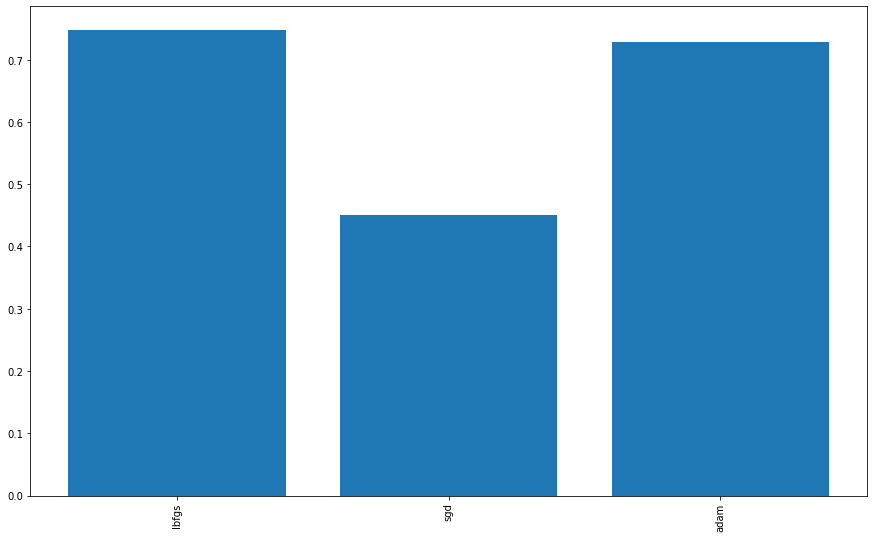

In [20]:
plt.figure(figsize=(15,9))
plt.bar(x=(result['param_solver'].apply(lambda x: str(x))), height=result['mean_test_score'])
plt.xticks(rotation=90)
plt.show()

The 'lbgfs' and 'adam' solvers appear to be comparable in their effects on accuracy, however the 'sgd' solver produces models that are significantly less accurate. Therefore, we will not use this solver going forward.

#### Hidden Layers

In [21]:
parameter_grid = {
    'hidden_layer_sizes': [[100], [200], [300], [100, 100], [200, 200], [300, 300], [100, 100, 100], [200, 200, 200], [300, 300, 300]],
}
mlp_grid = MLPClassifier(random_state=42, max_iter=10000)
gs_mlp = GridSearchCV(mlp_grid, parameter_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_mlp.fit(X, y)
print('Best values:')
for key, value in gs_mlp.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('The accuracy: %.4f\n' % gs_mlp.best_score_)

Best values:
Best value for "hidden_layer_sizes": [200]
The accuracy: 0.7488



In [22]:
result = pd.DataFrame(gs_mlp.cv_results_)
result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,2.916770,0.162673,0.003300,0.000640,[200],{'hidden_layer_sizes': [200]},0.6875,0.866667,0.800000,0.600000,0.866667,0.733333,0.866667,0.600000,0.600000,0.866667,0.748750,0.113408,1
5,4.312263,0.202777,0.003699,0.000460,"[300, 300]","{'hidden_layer_sizes': [300, 300]}",0.7500,0.866667,0.733333,0.666667,0.800000,0.733333,0.800000,0.600000,0.666667,0.866667,0.748333,0.083150,2
3,1.939736,0.117907,0.003000,0.000632,"[100, 100]","{'hidden_layer_sizes': [100, 100]}",0.7500,0.866667,0.733333,0.600000,0.733333,0.733333,0.800000,0.600000,0.733333,0.866667,0.741667,0.086683,3
2,3.189847,0.120209,0.003000,0.000775,[300],{'hidden_layer_sizes': [300]},0.6875,0.800000,0.733333,0.600000,0.800000,0.733333,0.866667,0.600000,0.666667,0.866667,0.735417,0.093006,4
4,2.907645,0.169435,0.003499,0.000671,"[200, 200]","{'hidden_layer_sizes': [200, 200]}",0.6875,0.866667,0.733333,0.600000,0.733333,0.733333,0.800000,0.600000,0.733333,0.866667,0.735417,0.088098,4
0,2.298059,0.183534,0.003451,0.000722,[100],{'hidden_layer_sizes': [100]},0.6875,0.800000,0.800000,0.600000,0.733333,0.733333,0.866667,0.666667,0.533333,0.866667,0.728750,0.104191,6
6,1.891029,0.256558,0.003500,0.000671,"[100, 100, 100]","{'hidden_layer_sizes': [100, 100, 100]}",0.7500,0.800000,0.666667,0.666667,0.733333,0.733333,0.800000,0.533333,0.666667,0.866667,0.721667,0.088835,7
8,4.102956,0.679984,0.003595,0.000798,"[300, 300, 300]","{'hidden_layer_sizes': [300, 300, 300]}",0.7500,0.800000,0.733333,0.666667,0.733333,0.800000,0.666667,0.533333,0.600000,0.866667,0.715000,0.095000,8
7,2.762130,0.619248,0.003300,0.000640,"[200, 200, 200]","{'hidden_layer_sizes': [200, 200, 200]}",0.6875,0.733333,0.800000,0.600000,0.600000,0.800000,0.800000,0.600000,0.600000,0.866667,0.708750,0.099136,9


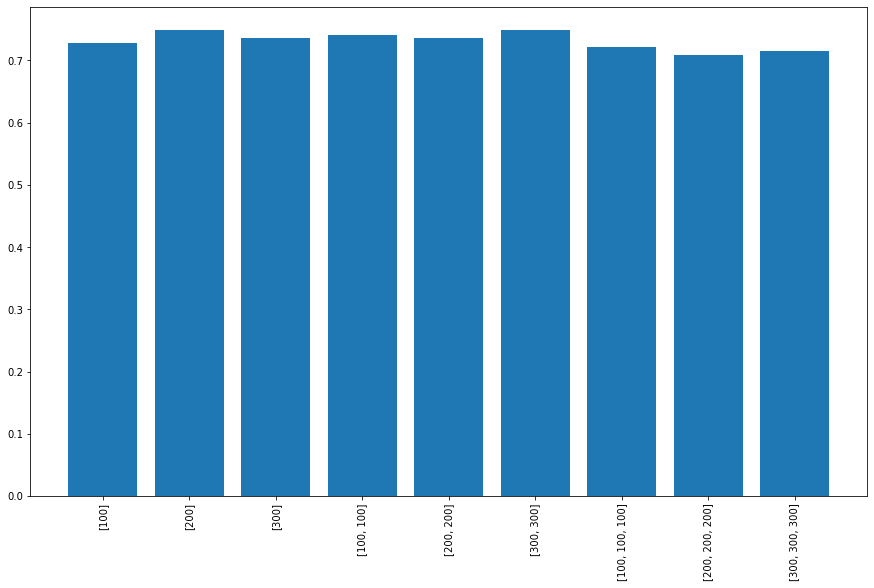

In [23]:
plt.figure(figsize=(15,9))
plt.bar(x=(result['param_hidden_layer_sizes'].apply(lambda x: str(x))), height=result['mean_test_score'])
plt.xticks(rotation=90)
plt.show()

Increasing the number of hidden layers above 2 appear to have a detrimental effect on accuracy. Therefore, we will only explore models using 1 or 2 hidden layers.

#### Activation

In [24]:
parameter_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu']
}
mlp_grid = MLPClassifier(random_state=42, max_iter=10000)
gs_mlp = GridSearchCV(mlp_grid, parameter_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_mlp.fit(X, y)
print('Best values:')
for key, value in gs_mlp.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('The accuracy: %.4f\n' % gs_mlp.best_score_)

Best values:
Best value for "activation": identity
The accuracy: 0.7621



In [25]:
result = pd.DataFrame(gs_mlp.cv_results_)
result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.583147,0.046156,0.0030,0.000634,identity,{'activation': 'identity'},0.6875,0.866667,0.800000,0.6,0.866667,0.800000,0.866667,0.666667,0.600000,0.866667,0.762083,0.106694,1
2,1.990896,0.036970,0.0029,0.000943,tanh,{'activation': 'tanh'},0.6875,0.866667,0.800000,0.6,0.866667,0.800000,0.866667,0.600000,0.600000,0.866667,0.755417,0.114262,2
1,3.756302,0.155271,0.0032,0.000400,logistic,{'activation': 'logistic'},0.6875,0.866667,0.866667,0.6,0.866667,0.733333,0.800000,0.600000,0.600000,0.866667,0.748750,0.113408,3
3,2.280040,0.176968,0.0033,0.000781,relu,{'activation': 'relu'},0.6875,0.800000,0.800000,0.6,0.733333,0.733333,0.866667,0.666667,0.533333,0.866667,0.728750,0.104191,4


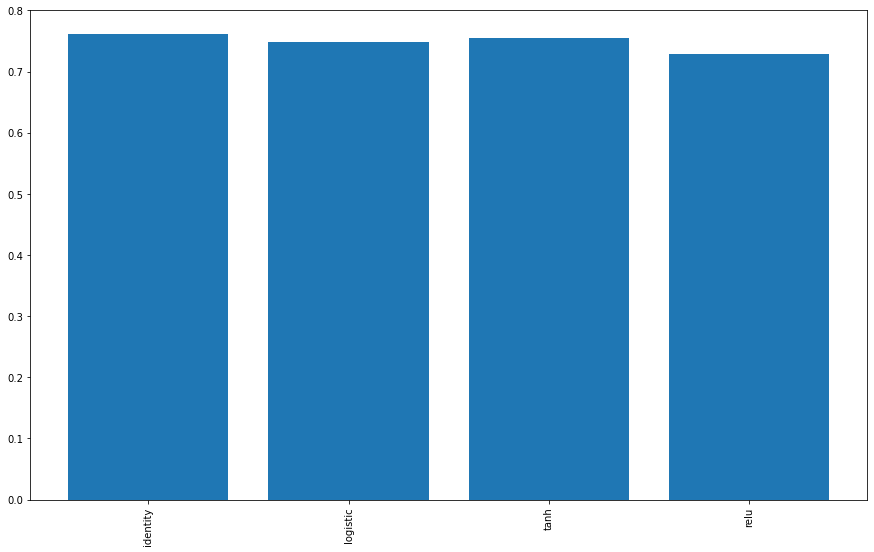

In [26]:
plt.figure(figsize=(15,9))
plt.bar(x=result['param_activation'], height=result['mean_test_score'])
plt.xticks(rotation=90)
plt.show()

#### Alpha

In [27]:
parameter_grid = {
    'alpha': 1/10**np.arange(0, 7)
}
mlp_grid = MLPClassifier(random_state=42, max_iter=10000)
gs_mlp = GridSearchCV(mlp_grid, parameter_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_mlp.fit(X, y)
print('Best values:')
for key, value in gs_mlp.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('The accuracy: %.4f\n' % gs_mlp.best_score_)

Best values:
Best value for "alpha": 1e-06
The accuracy: 0.7488



In [28]:
result = pd.DataFrame(gs_mlp.cv_results_)
result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
6,2.418192,0.107791,0.002989,0.000775,0.000001,{'alpha': 1e-06},0.6875,0.800000,0.800000,0.6,0.800000,0.800000,0.866667,0.666667,0.600000,0.866667,0.748750,0.096466,1
3,2.193345,0.098408,0.002799,0.000400,0.001,{'alpha': 0.001},0.6875,0.733333,0.800000,0.6,0.800000,0.800000,0.866667,0.666667,0.600000,0.866667,0.742083,0.094986,2
5,2.237331,0.103364,0.003299,0.000641,0.00001,{'alpha': 1e-05},0.6875,0.800000,0.733333,0.6,0.800000,0.733333,0.866667,0.666667,0.600000,0.866667,0.735417,0.093006,3
1,1.463946,0.086934,0.003329,0.000425,0.1,{'alpha': 0.1},0.7500,0.800000,0.866667,0.6,0.666667,0.733333,0.866667,0.666667,0.600000,0.800000,0.735000,0.094413,4
4,2.367275,0.125092,0.003000,0.000632,0.0001,{'alpha': 0.0001},0.6875,0.800000,0.800000,0.6,0.733333,0.733333,0.866667,0.666667,0.533333,0.866667,0.728750,0.104191,5
2,2.088968,0.083666,0.002800,0.000980,0.01,{'alpha': 0.01},0.7500,0.800000,0.733333,0.6,0.733333,0.733333,0.866667,0.666667,0.533333,0.866667,0.728333,0.101119,6
0,0.545751,0.029759,0.003099,0.000538,1.0,{'alpha': 1.0},0.6250,0.400000,0.600000,0.6,0.600000,0.866667,0.733333,0.400000,0.666667,0.400000,0.589167,0.145871,7


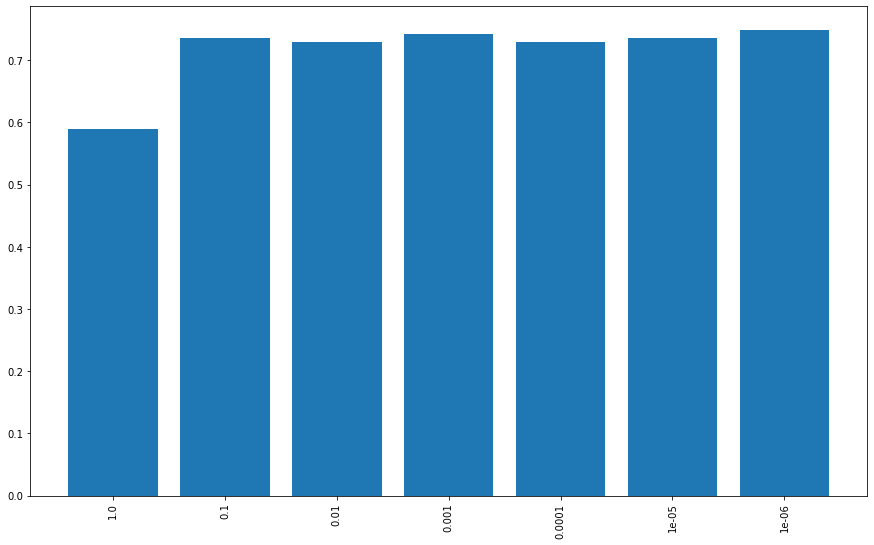

In [29]:
plt.figure(figsize=(15,9))
plt.bar(x=(result['param_alpha'].apply(lambda x: str(x))), height=result['mean_test_score'])
plt.xticks(rotation=90)
plt.show()

#### Combined

In [30]:
parameter_grid = {
    'hidden_layer_sizes': [[100], [200], [300], [100, 100], [200, 200], [300, 300]],
    'solver': ['lbfgs', 'adam'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
}
mlp_grid = MLPClassifier(max_iter=10000, random_state=42)
gs_mlp = GridSearchCV(mlp_grid, parameter_grid, scoring='accuracy', n_jobs=4, cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_mlp.fit(X, y)
print('Best values:')
for key, value in gs_mlp.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('The accuracy: %.4f\n' % gs_mlp.best_score_)

Best values:
Best value for "activation": logistic
Best value for "hidden_layer_sizes": [200]
Best value for "solver": lbfgs
The accuracy: 0.7688



In [31]:
result = pd.DataFrame(gs_mlp.cv_results_)
result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_solver,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
14,5.737414,0.547902,0.004300,0.000459,logistic,[200],lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.6875,0.866667,...,0.600000,0.733333,0.800000,0.933333,0.733333,0.600000,0.866667,0.768750,0.110856,1
1,2.608078,0.099348,0.004098,0.000540,identity,[100],adam,"{'activation': 'identity', 'hidden_layer_sizes...",0.6875,0.866667,...,0.600000,0.866667,0.800000,0.866667,0.666667,0.600000,0.866667,0.762083,0.106694,2
25,3.095507,0.192352,0.003898,0.000301,tanh,[100],adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6875,0.866667,...,0.600000,0.866667,0.800000,0.866667,0.600000,0.600000,0.866667,0.755417,0.114262,3
17,10.553505,0.598758,0.004399,0.000491,logistic,[300],adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.6875,0.866667,...,0.600000,0.800000,0.733333,0.866667,0.600000,0.666667,0.866667,0.755417,0.106198,3
24,3.368275,0.490501,0.004401,0.000662,tanh,[100],lbfgs,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6875,0.866667,...,0.533333,0.800000,0.733333,0.866667,0.733333,0.600000,0.800000,0.755417,0.118087,5
29,5.851395,0.144322,0.004400,0.000661,tanh,[300],adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6875,0.866667,...,0.600000,0.933333,0.800000,0.800000,0.600000,0.600000,0.866667,0.748750,0.117261,6
40,6.669718,1.151115,0.004501,0.000671,relu,[300],lbfgs,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.6875,0.733333,...,0.666667,0.800000,0.800000,0.866667,0.666667,0.600000,0.866667,0.748750,0.086764,6
13,5.365705,0.500019,0.003899,0.000300,logistic,[100],adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.6875,0.866667,...,0.600000,0.866667,0.733333,0.800000,0.600000,0.600000,0.866667,0.748750,0.113408,6
39,5.087968,0.125658,0.004104,0.000298,relu,[200],adam,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.6875,0.866667,...,0.600000,0.866667,0.733333,0.866667,0.600000,0.600000,0.866667,0.748750,0.113408,6
27,4.498500,0.148520,0.004199,0.000599,tanh,[200],adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6875,0.866667,...,0.600000,0.866667,0.800000,0.800000,0.600000,0.600000,0.866667,0.748750,0.109418,10


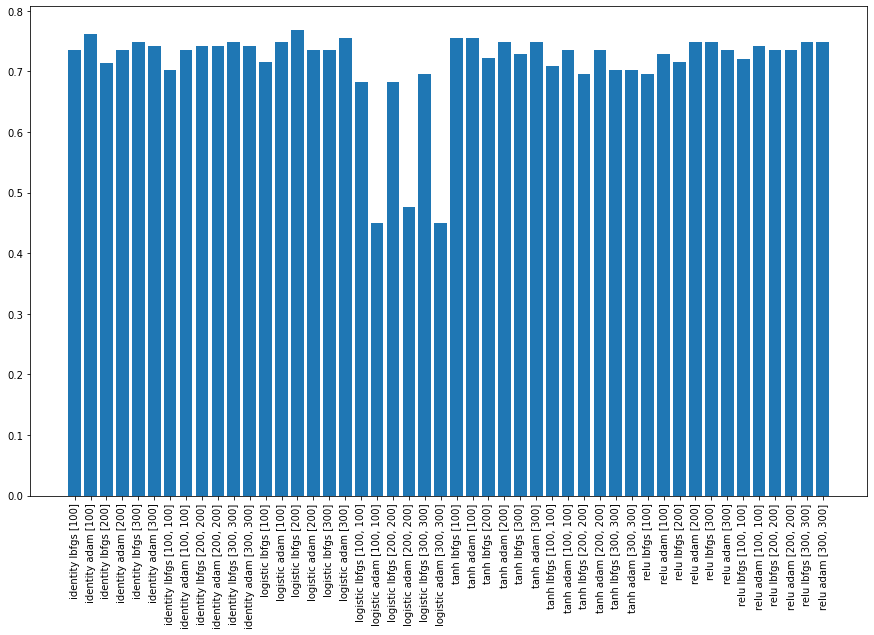

In [32]:
plt.figure(figsize=(15,9))
plt.bar(x=(result['param_activation'] + ' ' + result['param_solver'] + ' ' + result['param_hidden_layer_sizes'].apply(lambda x: str(x))), height=result['mean_test_score'])
plt.xticks(rotation=90)
plt.show()

### Decision Tree

In [33]:
X = all_df_norm_major_groups.drop(columns=['PreferencePercent', 'PartyNm'])
y = all_df_norm_major_groups['PartyNm']
train, test = train_test_split(all_df_norm_major_groups, test_size=0.2, random_state=42)
train_X = train.drop(columns=['PreferencePercent','PartyNm'])
train_y = train['PartyNm']
test_X = test.drop(columns=['PreferencePercent','PartyNm'])
test_y = test['PartyNm']

In [34]:
dt = DecisionTreeClassifier(random_state=42, max_depth=3, criterion='gini', splitter='best')
dt.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [35]:
print(accuracy_score(train_y, dt.predict(train_X)))
print(accuracy_score(test_y, dt.predict(test_X)))

0.9083333333333333
0.5806451612903226


In [36]:
pd.DataFrame(confusion_matrix(test_y, dt.predict(test_X)))

,0,1,2
0,7,6,0
1,4,11,0
2,2,1,0


In [37]:
result = pd.DataFrame(test['PartyNm'])
result.columns = ["Actual"]
result.insert(1, "Predicted", dt.predict(test_X))
result.insert(2, "Pref Percent", test['PreferencePercent'].values)
display(result)

,Actual,Predicted,Pref Percent
LGA,,,
Hughes,Coalition,Coalition,59.85
Brand,ALP,ALP,56.66
Kennedy,Independent/Minor,Coalition,63.33
Jagajaga,ALP,Coalition,56.57
Warringah,Independent/Minor,ALP,57.24
Cook,Coalition,Coalition,69.02
Hunter,ALP,ALP,52.98
Grayndler,ALP,ALP,66.30
Fowler,ALP,Coalition,63.99


In [38]:
dt_cv = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(dt_cv, X, y, cv=10)
print('Accuracy range for Decision tree: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))

Accuracy range for Decision tree: [0.2667, 0.8667]; mean: 0.6750; std: 0.1569



C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


### Decision Tree hyper-parameter optimisation

In [39]:
parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 16),
}
dt_grid = DecisionTreeClassifier(random_state=42)
gs_dt = GridSearchCV(dt_grid, parameter_grid, scoring='accuracy', n_jobs=4, cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_dt.fit(X, y)
print('Best values:')
for key, value in gs_dt.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('The accuracy: %.4f\n' % gs_dt.best_score_)

Best values:
Best value for "criterion": gini
Best value for "max_depth": 3
Best value for "splitter": best
The accuracy: 0.7371



In [40]:
result = pd.DataFrame(gs_dt.cv_results_)
result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_splitter,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
4,0.006900,0.001375,0.002701,8.995331e-04,gini,3,best,"{'criterion': 'gini', 'max_depth': 3, 'splitte...",0.4375,0.666667,...,0.866667,0.733333,0.800000,0.733333,0.800000,0.666667,0.866667,0.737083,0.120480,1
6,0.007999,0.001095,0.002800,7.489043e-04,gini,4,best,"{'criterion': 'gini', 'max_depth': 4, 'splitte...",0.4375,0.800000,...,0.666667,0.733333,0.733333,0.733333,0.800000,0.666667,0.866667,0.723750,0.112516,2
3,0.003300,0.000783,0.001900,5.410169e-04,gini,2,random,"{'criterion': 'gini', 'max_depth': 2, 'splitte...",0.4375,0.600000,...,0.733333,0.666667,0.800000,0.733333,0.733333,0.733333,0.866667,0.717083,0.121284,3
42,0.014599,0.002200,0.002604,6.640345e-04,entropy,7,best,"{'criterion': 'entropy', 'max_depth': 7, 'spli...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.709583,0.158180,4
2,0.005499,0.000671,0.002600,9.173415e-04,gini,2,best,"{'criterion': 'gini', 'max_depth': 2, 'splitte...",0.5000,0.600000,...,0.800000,0.800000,0.600000,0.600000,0.733333,0.666667,0.800000,0.703333,0.125122,5
52,0.014077,0.003545,0.002198,3.934028e-04,entropy,12,best,"{'criterion': 'entropy', 'max_depth': 12, 'spl...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.702917,0.169292,6
54,0.014470,0.002214,0.002397,4.862448e-04,entropy,13,best,"{'criterion': 'entropy', 'max_depth': 13, 'spl...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.702917,0.169292,6
46,0.014800,0.002856,0.002300,7.808653e-04,entropy,9,best,"{'criterion': 'entropy', 'max_depth': 9, 'spli...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.702917,0.169292,6
56,0.013050,0.002694,0.002354,5.559749e-04,entropy,14,best,"{'criterion': 'entropy', 'max_depth': 14, 'spl...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.702917,0.169292,6
48,0.012899,0.002300,0.002501,8.065398e-04,entropy,10,best,"{'criterion': 'entropy', 'max_depth': 10, 'spl...",0.5625,0.733333,...,0.733333,1.000000,0.600000,0.600000,0.800000,0.666667,0.933333,0.702917,0.169292,6


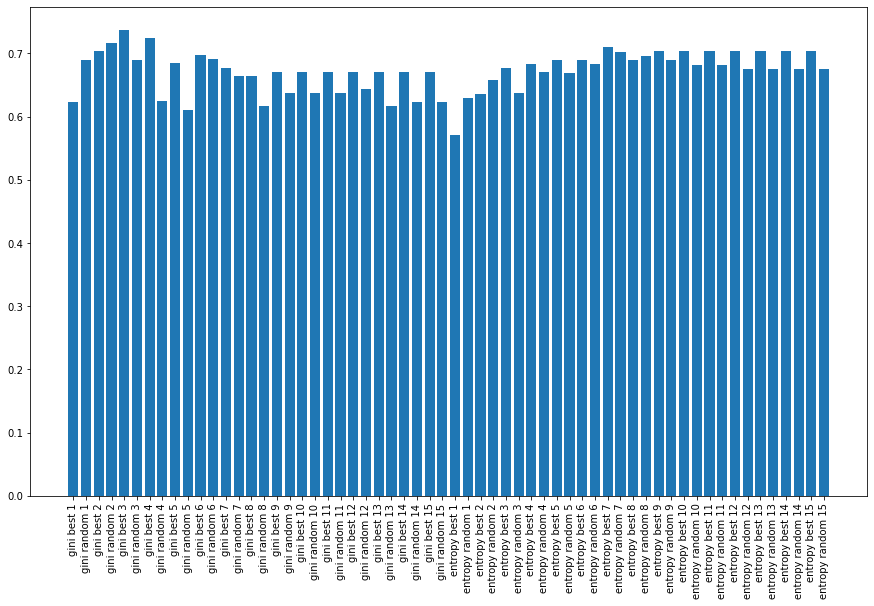

In [41]:
plt.figure(figsize=(15,9))
plt.bar(x=(result['param_criterion'] + ' ' + result['param_splitter'] + ' ' + result['param_max_depth'].apply(lambda x: str(x))), height=result['mean_test_score'])
plt.xticks(rotation=90)
plt.show()

### Random Forest

In [42]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', n_estimators=200)
rf.fit(train_X, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=42)

In [43]:
print(accuracy_score(train_y, rf.predict(train_X)))
print(accuracy_score(test_y, rf.predict(test_X)))

1.0
0.6774193548387096


In [44]:
pd.DataFrame(confusion_matrix(test_y, rf.predict(test_X)))

,0,1,2
0,8,5,0
1,2,13,0
2,1,2,0


In [45]:
result = pd.DataFrame(test['PartyNm'])
result.columns = ["Actual"]
result.insert(1, "Predicted", rf.predict(test_X))
result.insert(2, "Pref Percent", test['PreferencePercent'].values)
display(result)

,Actual,Predicted,Pref Percent
LGA,,,
Hughes,Coalition,Coalition,59.85
Brand,ALP,ALP,56.66
Kennedy,Independent/Minor,Coalition,63.33
Jagajaga,ALP,Coalition,56.57
Warringah,Independent/Minor,Coalition,57.24
Cook,Coalition,Coalition,69.02
Hunter,ALP,Coalition,52.98
Grayndler,ALP,ALP,66.30
Fowler,ALP,ALP,63.99


In [46]:
rf_cv = RandomForestClassifier(random_state=42)
scores = cross_val_score(rf_cv, X, y, cv=10)
print('Accuracy range for Random Forest: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))

C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Accuracy range for Random Forest: [0.6667, 0.9333]; mean: 0.7750; std: 0.0847



### Random Forest hyper-parameter optimisation

In [47]:
parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(50, 301, 25)
}
rf_grid = RandomForestClassifier()
gs_rf = GridSearchCV(rf_grid, parameter_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_rf.fit(X, y)
print('Best values:')
for key, value in gs_rf.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('The accuracy: %.4f\n' % gs_rf.best_score_)

Best values:
Best value for "criterion": entropy
Best value for "n_estimators": 175
The accuracy: 0.7700



In [48]:
result = pd.DataFrame(gs_rf.cv_results_)
result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
16,0.239166,0.008280,0.012980,0.000454,entropy,175,"{'criterion': 'entropy', 'n_estimators': 175}",0.5000,0.800000,0.800000,0.800000,0.666667,0.800000,0.733333,0.866667,0.800000,0.933333,0.770000,0.112002,1
4,0.173087,0.005503,0.012037,0.000783,gini,150,"{'criterion': 'gini', 'n_estimators': 150}",0.5000,0.800000,0.800000,0.800000,0.600000,0.800000,0.733333,0.866667,0.800000,0.933333,0.763333,0.119675,2
9,0.311772,0.008798,0.019008,0.000896,gini,275,"{'criterion': 'gini', 'n_estimators': 275}",0.5000,0.800000,0.733333,0.800000,0.666667,0.800000,0.733333,0.933333,0.800000,0.866667,0.763333,0.112002,3
1,0.086830,0.003151,0.006991,0.000636,gini,75,"{'criterion': 'gini', 'n_estimators': 75}",0.5625,0.733333,0.866667,0.866667,0.800000,0.733333,0.733333,0.800000,0.733333,0.800000,0.762917,0.083259,4
11,0.069114,0.001159,0.005310,0.000460,entropy,50,"{'criterion': 'entropy', 'n_estimators': 50}",0.5625,0.800000,0.800000,0.733333,0.666667,0.800000,0.733333,0.800000,0.800000,0.933333,0.762917,0.093327,4
2,0.115422,0.003580,0.008396,0.000487,gini,100,"{'criterion': 'gini', 'n_estimators': 100}",0.5000,0.800000,0.866667,0.733333,0.600000,0.800000,0.733333,0.866667,0.800000,0.866667,0.756667,0.115518,6
3,0.147105,0.007384,0.010247,0.001202,gini,125,"{'criterion': 'gini', 'n_estimators': 125}",0.5625,0.800000,0.800000,0.733333,0.666667,0.733333,0.733333,0.933333,0.733333,0.866667,0.756250,0.097490,7
17,0.276682,0.007870,0.016087,0.002389,entropy,200,"{'criterion': 'entropy', 'n_estimators': 200}",0.5625,0.800000,0.866667,0.733333,0.600000,0.800000,0.733333,0.866667,0.733333,0.866667,0.756250,0.101947,7
6,0.226592,0.004872,0.014507,0.000920,gini,200,"{'criterion': 'gini', 'n_estimators': 200}",0.4375,0.800000,0.733333,0.733333,0.666667,0.866667,0.733333,0.866667,0.733333,0.933333,0.750417,0.130017,9
12,0.103574,0.002392,0.007201,0.000400,entropy,75,"{'criterion': 'entropy', 'n_estimators': 75}",0.5625,0.733333,0.866667,0.733333,0.733333,0.733333,0.600000,0.866667,0.733333,0.933333,0.749583,0.109488,10


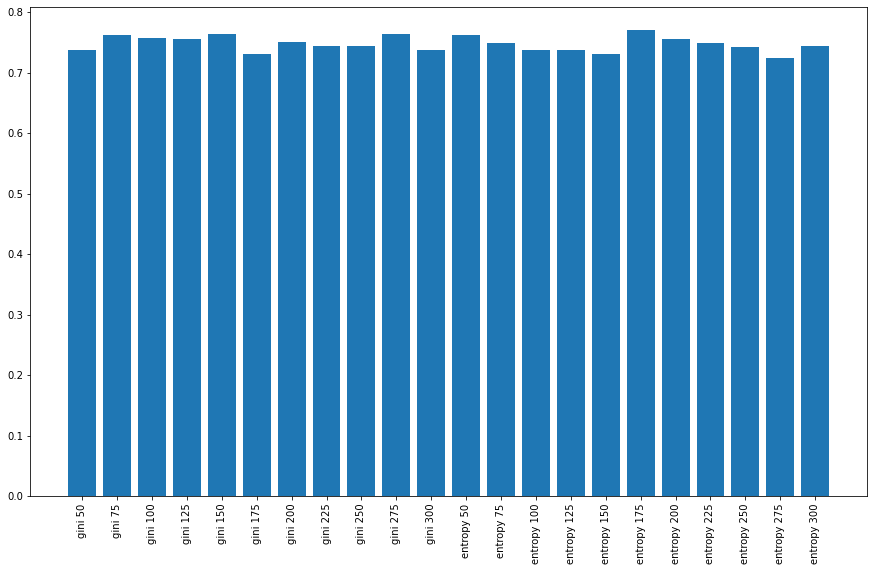

In [49]:
plt.figure(figsize=(15,9))
plt.bar(x=(result['param_criterion'] + ' ' + result['param_n_estimators'].apply(lambda x: str(x))), height=result['mean_test_score'])
plt.xticks(rotation=90)
plt.show()

### MLP (grouped)

In [50]:
group_X = all_df_norm_major_groups.drop(columns=['PreferencePercent', 'PartyNm'])
group_y = all_df_norm_major_groups['PartyNm']
group_train, group_test = train_test_split(all_df_norm_major_groups, test_size=0.2, random_state=42)
group_train_X = group_train.drop(columns=['PreferencePercent','PartyNm'])
group_train_y = group_train['PartyNm']
group_test_X = group_test.drop(columns=['PreferencePercent','PartyNm'])
group_test_y = group_test['PartyNm']

In [51]:
mlp_group = MLPClassifier(random_state=42, hidden_layer_sizes=[200, 200], solver='adam', activation='tanh', max_iter=10000)
mlp_group.fit(group_train_X, group_train_y)

MLPClassifier(activation='tanh', hidden_layer_sizes=[200, 200], max_iter=10000,
              random_state=42)

In [52]:
print(accuracy_score(group_train_y, mlp_group.predict(group_train_X)))
print(accuracy_score(group_test_y, mlp_group.predict(group_test_X)))

0.9416666666666667
0.7096774193548387


In [53]:
pd.DataFrame(confusion_matrix(group_test_y, mlp_group.predict(group_test_X)))

,0,1,2
0,9,4,0
1,2,13,0
2,1,2,0


In [54]:
result = pd.DataFrame(group_test['PartyNm'])
result.columns = ["Actual"]
result.insert(1, "Predicted", mlp_group.predict(group_test_X))
result.insert(2, "Pref Percent", group_test['PreferencePercent'].values)
display(result)

,Actual,Predicted,Pref Percent
LGA,,,
Hughes,Coalition,Coalition,59.85
Brand,ALP,Coalition,56.66
Kennedy,Independent/Minor,Coalition,63.33
Jagajaga,ALP,ALP,56.57
Warringah,Independent/Minor,Coalition,57.24
Cook,Coalition,Coalition,69.02
Hunter,ALP,Coalition,52.98
Grayndler,ALP,ALP,66.30
Fowler,ALP,ALP,63.99


### MLP (grouped) hyper-parameter optimisation

In [77]:
parameter_grid = {
    'hidden_layer_sizes': [[100], [200], [300], [100, 100], [200, 200], [300, 300]],
    'solver': ['lbfgs', 'adam'],
    'activation': ['identity', 'tanh', 'relu']
}
mlp_grid = MLPClassifier(max_iter=10000, random_state=42)
gs_mlp = GridSearchCV(mlp_grid, parameter_grid, scoring='accuracy', n_jobs=4, cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_mlp.fit(group_X, group_y)
print('Best values:')
for key, value in gs_mlp.best_params_.items():
    print(f'Best value for "{key}": {value}')
print('The accuracy: %.4f\n' % gs_mlp.best_score_)

Best values:
Best value for "activation": tanh
Best value for "hidden_layer_sizes": [200, 200]
Best value for "solver": adam
The accuracy: 0.7958



In [78]:
result = pd.DataFrame(gs_mlp.cv_results_)
result.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_solver,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
21,2.522459,0.388877,0.004398,0.000662,tanh,"[200, 200]",adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.800000,0.800000,0.800000,0.800000,0.933333,0.600000,0.933333,0.795833,0.105096,1
17,5.381282,0.755356,0.004599,0.000489,tanh,[300],adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.866667,0.800000,0.666667,0.933333,0.789167,0.088510,2
3,3.705071,0.353754,0.004698,0.000900,identity,[200],adam,"{'activation': 'identity', 'hidden_layer_sizes...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.800000,0.866667,0.666667,0.933333,0.789167,0.088510,2
25,3.080542,0.209338,0.004005,0.000632,relu,[100],adam,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.800000,0.933333,0.666667,0.933333,0.789167,0.098040,2
13,2.630806,0.163188,0.004401,0.000490,tanh,[100],adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.800000,0.866667,0.666667,0.933333,0.789167,0.088510,2
27,5.487214,0.333911,0.004499,0.000671,relu,[200],adam,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.800000,0.866667,0.666667,0.933333,0.782500,0.089942,6
5,4.883237,0.515715,0.004945,0.000720,identity,[300],adam,"{'activation': 'identity', 'hidden_layer_sizes...",0.6250,0.800000,...,0.866667,0.733333,0.800000,0.800000,0.866667,0.666667,0.933333,0.782500,0.089942,6
1,2.030013,0.151156,0.004101,0.000300,identity,[100],adam,"{'activation': 'identity', 'hidden_layer_sizes...",0.6250,0.800000,...,0.866667,0.733333,0.733333,0.800000,0.866667,0.666667,0.933333,0.782500,0.089942,8
7,1.041268,0.175832,0.004701,0.000781,identity,"[100, 100]",adam,"{'activation': 'identity', 'hidden_layer_sizes...",0.6250,0.800000,...,0.733333,0.733333,0.800000,0.866667,0.933333,0.666667,0.933333,0.782500,0.099335,8
15,3.980355,0.291439,0.004899,0.000701,tanh,[200],adam,"{'activation': 'tanh', 'hidden_layer_sizes': [...",0.6250,0.800000,...,0.866667,0.733333,0.733333,0.866667,0.800000,0.666667,0.933333,0.782500,0.089942,8


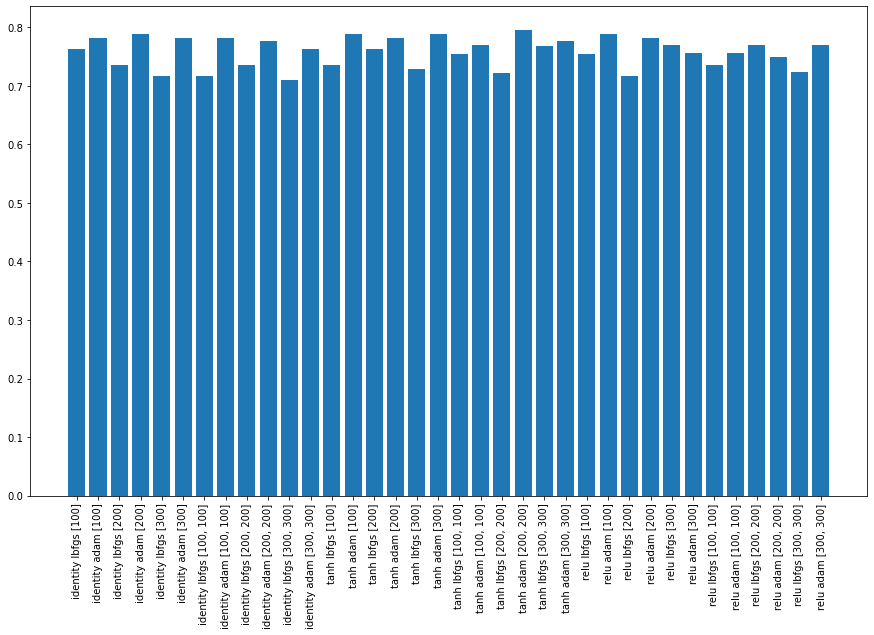

In [79]:
plt.figure(figsize=(15,9))
plt.bar(x=(result['param_activation'] + ' ' + result['param_solver'] + ' ' + result['param_hidden_layer_sizes'].apply(lambda x: str(x))), height=result['mean_test_score'])
plt.xticks(rotation=90)
plt.show()

### Model comparison

In [58]:
mlp_group

MLPClassifier(activation='tanh', hidden_layer_sizes=[200, 200], max_iter=10000,
              random_state=42)

### Permutation Importance of MLP

#### Grouped parties

In [59]:
perm_group = PermutationImportance(mlp_group, random_state=42, cv=KFold(n_splits=10, shuffle=True, random_state=42)).fit(test_X, test_y)

C:\Users\micha\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [60]:
result = pd.DataFrame(test_X.columns, columns=['label'])
result.insert(1, "feature importance", perm_group.feature_importances_)
result = result.set_index('label')
result.sort_values('feature importance', ascending=False)

,feature importance
label,
RELP - Christianity,0.080000
RLHP - Lone person,0.071667
"LFHRP - Employed, worked part-time",0.060000
GNGP - National Government,0.055000
LFHRP - Not applicable,0.053333
...,...
MDCP - Not married,-0.006667
GNGP - State/Territory Government,-0.006667
MDCP - Married in a registered marriage,-0.006667


<ipython-input-61-b6a82026b9bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_no_zeroes['code'] = result_no_zeroes.reset_index()['label'].apply(lambda x: x[0:5])


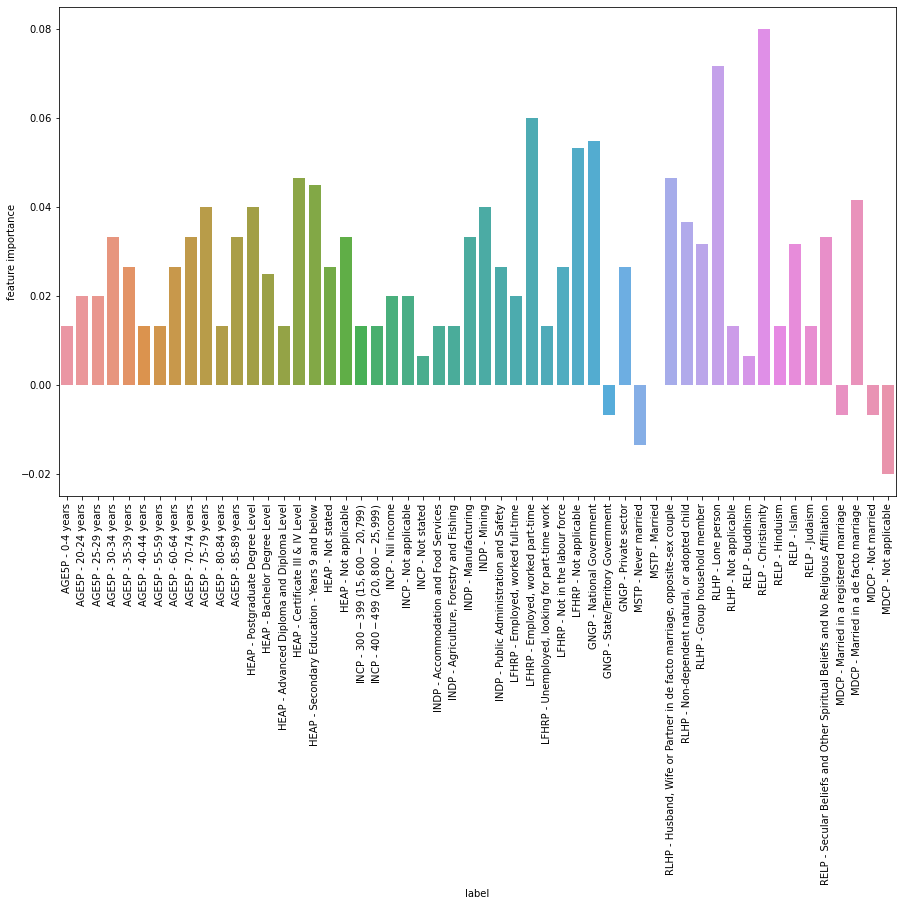

In [61]:
result_no_zeroes = result[result['feature importance'] != 0]
result_no_zeroes['code'] = result_no_zeroes.reset_index()['label'].apply(lambda x: x[0:5])

plt.figure(figsize=(15,9))
sns.barplot(data=result_no_zeroes, x=result_no_zeroes.index, y='feature importance')
plt.xticks(rotation=90)
plt.show()

In [62]:
result['feature importance'] > 0
group_X.loc[:,(result['feature importance'] > 0).values]

,AGE5P - 0-4 years,AGE5P - 20-24 years,AGE5P - 25-29 years,AGE5P - 30-34 years,AGE5P - 35-39 years,AGE5P - 40-44 years,AGE5P - 55-59 years,AGE5P - 60-64 years,AGE5P - 70-74 years,AGE5P - 75-79 years,...,RLHP - Group household member,RLHP - Lone person,RLHP - Not applicable,RELP - Buddhism,RELP - Christianity,RELP - Hinduism,RELP - Islam,RELP - Judaism,RELP - Secular Beliefs and Other Spiritual Beliefs and No Religious Affiliation,MDCP - Married in a de facto marriage
LGA,,,,,,,,,,,,,,,,,,,,,
Adelaide,0.053945,0.096777,0.092626,0.088211,0.070221,0.064358,0.058079,0.050950,0.030872,0.025434,...,0.076488,0.120685,0.051793,0.040264,0.430949,0.034115,0.042542,0.000863,0.339837,0.073786
Aston,0.058553,0.066246,0.064391,0.067479,0.066700,0.067842,0.068153,0.060999,0.036473,0.027386,...,0.017723,0.070529,0.024446,0.037948,0.498514,0.026030,0.011146,0.001038,0.339856,0.060754
Ballarat,0.062608,0.065860,0.060216,0.059006,0.059537,0.063918,0.065464,0.062218,0.043289,0.030333,...,0.032531,0.106681,0.034265,0.007862,0.507913,0.005241,0.003441,0.000564,0.374349,0.081842
Banks,0.060613,0.068598,0.074162,0.073559,0.066018,0.066666,0.065087,0.054882,0.035024,0.028760,...,0.027366,0.071816,0.017688,0.042913,0.555461,0.031552,0.048503,0.001181,0.242016,0.044820
Barker,0.055697,0.050169,0.051558,0.054241,0.054597,0.061491,0.072746,0.069913,0.049359,0.035917,...,0.021013,0.110423,0.037166,0.006500,0.527855,0.001740,0.006065,0.000187,0.354199,0.078180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Werriwa,0.072655,0.072380,0.065587,0.071789,0.070232,0.071227,0.059197,0.046687,0.024476,0.018455,...,0.008987,0.039531,0.011340,0.075201,0.528710,0.049252,0.127320,0.000123,0.112792,0.039473
Whitlam,0.060113,0.055673,0.052804,0.056448,0.056678,0.063652,0.066568,0.060040,0.049678,0.038173,...,0.015006,0.082399,0.029894,0.008222,0.641086,0.003651,0.012516,0.000749,0.252983,0.067582
Wide Bay,0.048858,0.042020,0.040191,0.044199,0.049902,0.060777,0.079064,0.078959,0.061919,0.040660,...,0.027668,0.100018,0.037227,0.009684,0.551459,0.001731,0.000778,0.000750,0.321404,0.080181


In [63]:
group_train_small, group_test_small = train_test_split(all_df_norm_major_groups, test_size=0.2, random_state=42)
group_train_small_X = group_train_small.drop(columns=['PreferencePercent','PartyNm']).loc[:,(result['feature importance'] > 0.05).values]
group_train_small_y = group_train_small['PartyNm']
group_test_small_X = group_test_small.drop(columns=['PreferencePercent','PartyNm']).loc[:,(result['feature importance'] > 0.05).values]
group_test_small_y = group_test_small['PartyNm']

In [64]:
mlp_group_small = MLPClassifier(random_state=42, hidden_layer_sizes=[200,200], solver='adam', activation='tanh', max_iter=10000)
mlp_group_small.fit(group_train_small_X, group_train_small_y)

MLPClassifier(activation='tanh', hidden_layer_sizes=[200, 200], max_iter=10000,
              random_state=42)

In [65]:
print(accuracy_score(group_train_small_y, mlp_group_small.predict(group_train_small_X)))
print(accuracy_score(group_test_small_y, mlp_group_small.predict(group_test_small_X)))

0.7
0.6451612903225806


In [1]:
perm_results = pd.DataFrame(columns=['Cutoff', 'Train Acc', 'Test Acc'])

for i in np.arange(0, 0.08, 0.005):
    print('Cutoff:', i)
    group_train_small, group_test_small = train_test_split(all_df_norm_major_groups, test_size=0.1, random_state=42)
    group_train_small_X = group_train_small.drop(columns=['PreferencePercent','PartyNm']).loc[:,(result['feature importance'] > i).values]
    group_train_small_y = group_train_small['PartyNm']
    group_test_small_X = group_test_small.drop(columns=['PreferencePercent','PartyNm']).loc[:,(result['feature importance'] > i).values]
    group_test_small_y = group_test_small['PartyNm']
    
    mlp_group_small = MLPClassifier(random_state=42, hidden_layer_sizes=[200,200], solver='adam', activation='tanh', max_iter=10000)
    mlp_group_small.fit(group_train_small_X, group_train_small_y)
    
    print("Training accuracy:", accuracy_score(group_train_small_y, mlp_group_small.predict(group_train_small_X)))
    print("Test accuracy:", accuracy_score(group_test_small_y, mlp_group_small.predict(group_test_small_X)), '\n')
    
    perm_results = perm_results.append({'Cutoff': str(i),
                                        'Train Acc': accuracy_score(group_train_small_y, mlp_group_small.predict(group_train_small_X)),
                                        'Test Acc': accuracy_score(group_test_small_y, mlp_group_small.predict(group_test_small_X))}
                                       , ignore_index=True)

NameError: name 'pd' is not defined

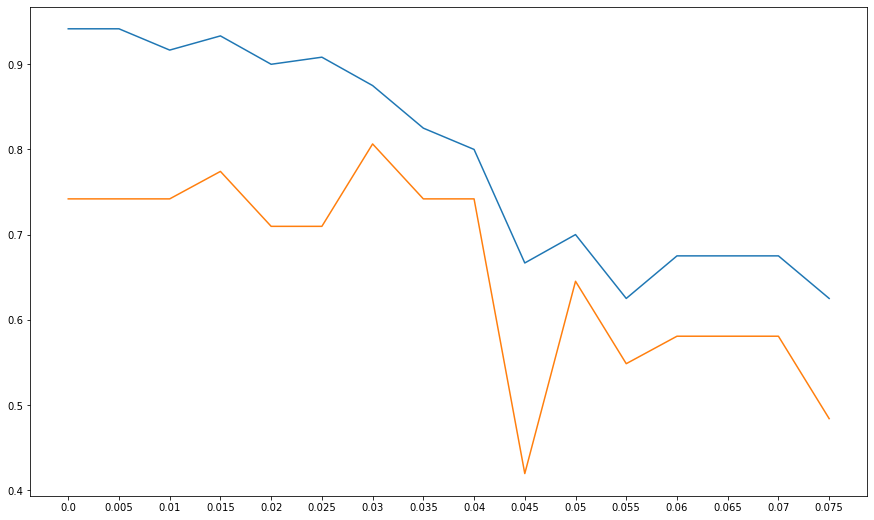

In [67]:
plt.figure(figsize=(15,9))
plt.plot(perm_results['Cutoff'], perm_results['Train Acc'])
plt.plot(perm_results['Cutoff'], perm_results['Test Acc'])

In [68]:
best_features = result[result['feature importance'] > 0.035]
best_features.sort_values('feature importance', ascending=False)

,feature importance
label,
RELP - Christianity,0.080000
RLHP - Lone person,0.071667
"LFHRP - Employed, worked part-time",0.060000
GNGP - National Government,0.055000
LFHRP - Not applicable,0.053333
HEAP - Certificate III & IV Level,0.046667
"RLHP - Husband, Wife or Partner in de facto marriage, opposite-sex couple",0.046667
HEAP - Secondary Education - Years 9 and below,0.045000
MDCP - Married in a de facto marriage,0.041667


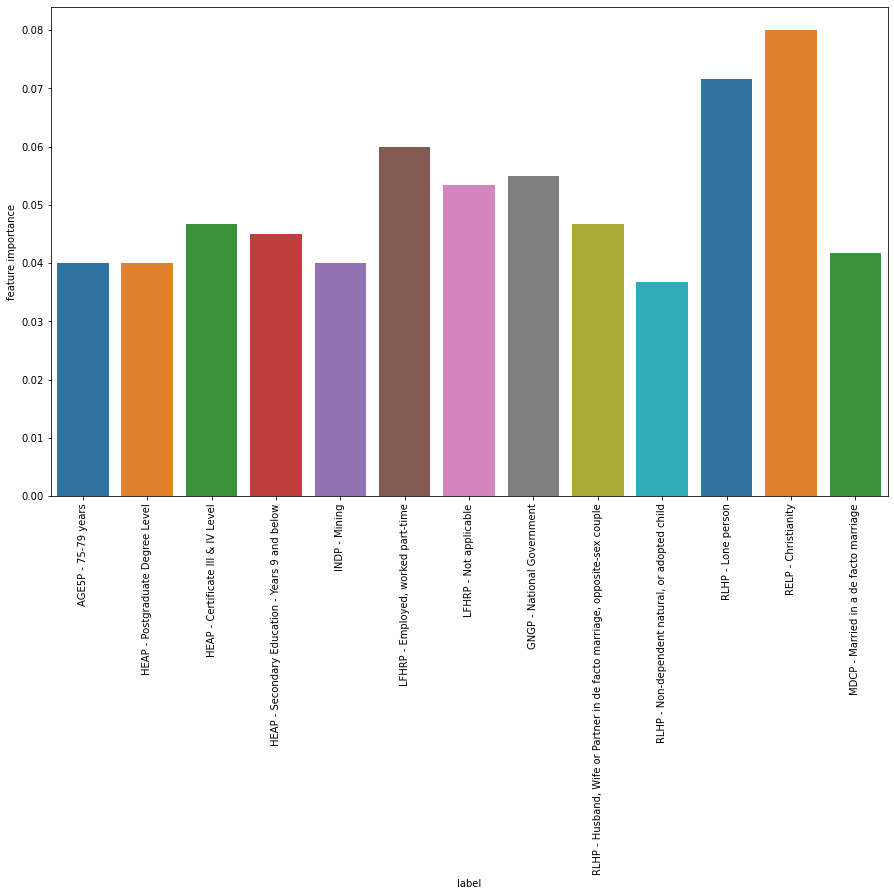

In [69]:
plt.figure(figsize=(15,9))
sns.barplot(data=best_features.reset_index(), x='label', y='feature importance', palette='tab10')
plt.xticks(rotation=90)
plt.show()

In [2]:
group_train_small, group_test_small = train_test_split(all_df_norm_major_groups, test_size=0.1, random_state=42)
group_train_small_X = group_train_small.drop(columns=['PreferencePercent','PartyNm']).loc[:,(result['feature importance'] > 0.035).values]
group_train_small_y = group_train_small['PartyNm']
group_test_small_X = group_test_small.drop(columns=['PreferencePercent','PartyNm']).loc[:,(result['feature importance'] > 0.035).values]
group_test_small_y = group_test_small['PartyNm']

mlp_final = MLPClassifier(random_state=42, hidden_layer_sizes=[200,200], solver='adam', activation='tanh', max_iter=10000)
mlp_final.fit(group_train_small_X, group_train_small_y)

NameError: name 'train_test_split' is not defined

In [71]:
print(accuracy_score(group_train_small_y, mlp_final.predict(group_train_small_X)))
print(accuracy_score(group_test_small_y, mlp_final.predict(group_test_small_X)))

0.825
0.7419354838709677


In [72]:
display(X.loc[:,(result['feature importance'] > 0.035).values])

,AGE5P - 75-79 years,HEAP - Postgraduate Degree Level,HEAP - Certificate III & IV Level,HEAP - Secondary Education - Years 9 and below,INDP - Mining,"LFHRP - Employed, worked part-time",LFHRP - Not applicable,GNGP - National Government,"RLHP - Husband, Wife or Partner in de facto marriage, opposite-sex couple","RLHP - Non-dependent natural, or adopted child",RLHP - Lone person,RELP - Christianity,MDCP - Married in a de facto marriage
LGA,,,,,,,,,,,,,
Adelaide,0.025434,0.061219,0.091596,0.062318,0.003700,0.162990,0.150061,0.023665,0.065003,0.042031,0.120685,0.430949,0.073786
Aston,0.027386,0.037120,0.137513,0.063383,0.000636,0.167851,0.175454,0.013716,0.055026,0.072859,0.070529,0.498514,0.060754
Ballarat,0.030333,0.026136,0.147880,0.082435,0.003360,0.161843,0.189994,0.014207,0.073962,0.047616,0.106681,0.507913,0.081842
Banks,0.028760,0.053481,0.101051,0.066458,0.000552,0.148142,0.175931,0.014622,0.036999,0.073806,0.071816,0.555461,0.044820
Barker,0.035917,0.008568,0.155868,0.100736,0.003584,0.155161,0.181763,0.004662,0.074079,0.041718,0.110423,0.527855,0.078180
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Werriwa,0.018455,0.023918,0.104515,0.078607,0.000497,0.117033,0.228741,0.010509,0.030953,0.094374,0.039531,0.528710,0.039473
Whitlam,0.038173,0.019904,0.171141,0.088204,0.008083,0.148290,0.190862,0.011984,0.060353,0.065120,0.082399,0.641086,0.067582
Wide Bay,0.040660,0.014247,0.164631,0.080549,0.006027,0.144258,0.173216,0.004345,0.073787,0.044830,0.100018,0.551459,0.080181


In [73]:
mlp_final_result = pd.DataFrame(y)
mlp_final_result.columns = ["Actual"]
mlp_final_result.insert(1, "Predicted", mlp_final.predict(X.loc[:,(result['feature importance'] > 0.035).values]))
mlp_final_result.insert(2, "Pref Percent", all_df['PreferencePercent'].values)
display(mlp_final_result)

,Actual,Predicted,Pref Percent
LGA,,,
Adelaide,ALP,ALP,58.18
Aston,Coalition,ALP,60.13
Ballarat,ALP,ALP,60.98
Banks,Coalition,ALP,56.26
Barker,Coalition,Coalition,68.94
...,...,...,...
Werriwa,ALP,ALP,55.47
Whitlam,ALP,Coalition,60.91
Wide Bay,Coalition,Coalition,63.15


In [74]:
print(accuracy_score(y,mlp_final.predict(X.loc[:,(result['feature importance'] > 0.035).values])))

0.8079470198675497


In [87]:
pd.DataFrame(confusion_matrix(mlp_final_result.iloc[:,0],mlp_final_result.iloc[:,1], labels=["Coalition", "ALP", "Minor/Independent"]))

,0,1,2
0,67,10,0
1,13,55,0
2,0,0,0


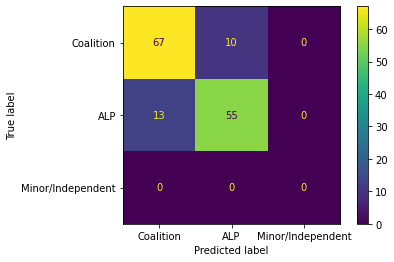

In [97]:
ConfusionMatrixDisplay(confusion_matrix(mlp_final_result.iloc[:,0],mlp_final_result.iloc[:,1],
                                        labels=["Coalition", "ALP", "Minor/Independent"]),
                                        display_labels=["Coalition", "ALP", "Minor/Independent"]).plot()
plt.show()